# Assignment 3 - Poisson Regression and Survival Analysis
SPPH 500 - Ly Trinh

### Question 1

The data set SkinCancer.txt contains data on non-melanoma skin cancer for individuals, grouped by age in two metropolitan areas: Dallas-Fort Worth and Minneapolis-St.Paul. The data also records the proportion of women in each strata. The variables recorded are: 

• AgeGroup: A=15-24, B=25-34, C=35-44, D=45-54, E=55-64, F=64-74, G=75-84, H=85+ \
• Location: The location of the women recorded as Dallas or Minneapolis \
• CancerCases: The numerical number of non-melanoma skin cancer cases, for each city and age group \
• PopSize: The numeric size of the population in each city/age group, used as the total number of people at risk. \
• PropWomen: The proportion of women in the groups.
 
The goal is to determine whether the risk of skin cancer is higher in Dallas than in Minneapolis. By risk, we mean the probability of developing non-melanoma skin cancer.  

In [1]:
# load packages
library(tidyverse) #for creating variables and plotting graphs with ggplots

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.5     v purrr   0.3.2
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
# load data set
SkinCancer <- read.delim('./SkinCancer.txt', header=T, sep="")
dim(SkinCancer) #dimensions (row x column)
SkinCancer
summary(SkinCancer)

[1] 16  5

AgeGroup,CancerCases,PopSize,Location,PropWomen
A,1,172675,Minnesota,0.53
B,16,123065,Minnesota,0.48
C,30,96216,Minnesota,0.51
D,71,92051,Minnesota,0.53
E,102,72159,Minnesota,0.45
F,130,54722,Minnesota,0.45
G,133,32185,Minnesota,0.45
H,40,8328,Minnesota,0.43
A,4,181343,Dallas,0.49
B,38,146207,Dallas,0.55


    AgeGroup  CancerCases       PopSize            Location   PropWomen     
 A      :2   Min.   :  1.0   Min.   :  7538   Dallas   :8   Min.   :0.4100  
 B      :2   1st Qu.: 36.0   1st Qu.: 49088   Minnesota:8   1st Qu.:0.4500  
 C      :2   Median : 86.5   Median : 87528                 Median :0.4750  
 D      :2   Mean   :110.3   Mean   : 86697                 Mean   :0.4775  
 E      :2   3rd Qu.:155.0   3rd Qu.:121797                 3rd Qu.:0.5125  
 F      :2   Max.   :310.0   Max.   :181343                 Max.   :0.5500  
 (Other):4                                                                  

In [3]:
#rename Minnesota to MSP and Dallas to DFW
SkinCancer <- SkinCancer %>%
    mutate(Location=recode_factor(Location, Dallas="DFW", Minnesota="MSP"))
summary(SkinCancer)

    AgeGroup  CancerCases       PopSize       Location   PropWomen     
 A      :2   Min.   :  1.0   Min.   :  7538   DFW:8    Min.   :0.4100  
 B      :2   1st Qu.: 36.0   1st Qu.: 49088   MSP:8    1st Qu.:0.4500  
 C      :2   Median : 86.5   Median : 87528            Median :0.4750  
 D      :2   Mean   :110.3   Mean   : 86697            Mean   :0.4775  
 E      :2   3rd Qu.:155.0   3rd Qu.:121797            3rd Qu.:0.5125  
 F      :2   Max.   :310.0   Max.   :181343            Max.   :0.5500  
 (Other):4                                                             

#### (a) Offsets:

In a few sentences, explain the idea of using an offset in Poisson Regression. That is, what is the purpose of the offset term?  When/Why do we include one?  Will we use an offset in our model, and if so, which variable will be the offset?

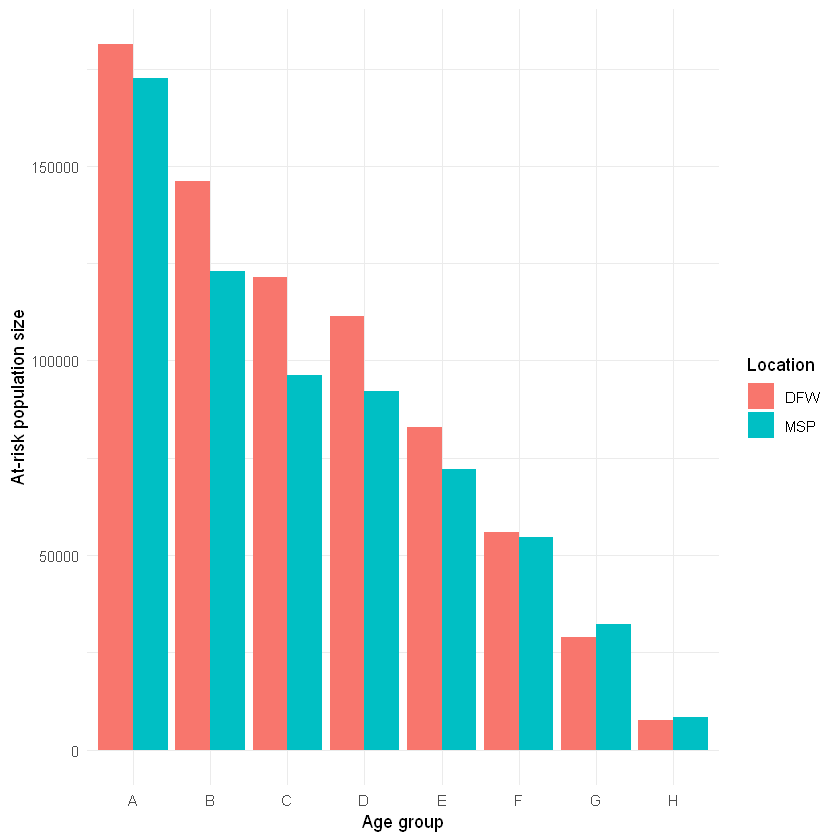

In [4]:
# plot of population size in each age group for each city
SkinCancer %>%
    ggplot()+
    geom_bar(aes(AgeGroup, PopSize, fill=Location),
             stat="identity", position="dodge")+
    theme_minimal()+
    labs(x="Age group", y="At-risk population size")

#### (b) Initial Examination:  

Make a plot of the observed cancer rates (per 100,000 people) for each age group in each location.  Make the same plot, but this time using the log of the observed rates (recall that Poisson regression models the log-rate as a linear function of the X’s).  Comment on any associations you observe from the plots.  Also comment on 
whether or not it appears that AgeGroup is an effect modifier of the Location effect. 

In [5]:
# plot of cancer rates per 100,000 people for each age group in each location
# create new variables for cancer rates per 100,000 ppl and log-cancer rate
SkinCancer <- SkinCancer %>%
    mutate(RatePer100k = CancerCases*100000/PopSize) %>%
    mutate(logRate = log(RatePer100k))
head(SkinCancer)

AgeGroup,CancerCases,PopSize,Location,PropWomen,RatePer100k,logRate
A,1,172675,MSP,0.53,0.5791226,-0.546241
B,16,123065,MSP,0.48,13.0012595,2.565046
C,30,96216,MSP,0.51,31.1798453,3.439772
D,71,92051,MSP,0.53,77.1311556,4.345507
E,102,72159,MSP,0.45,141.3545088,4.951271
F,130,54722,MSP,0.45,237.5644165,5.470439


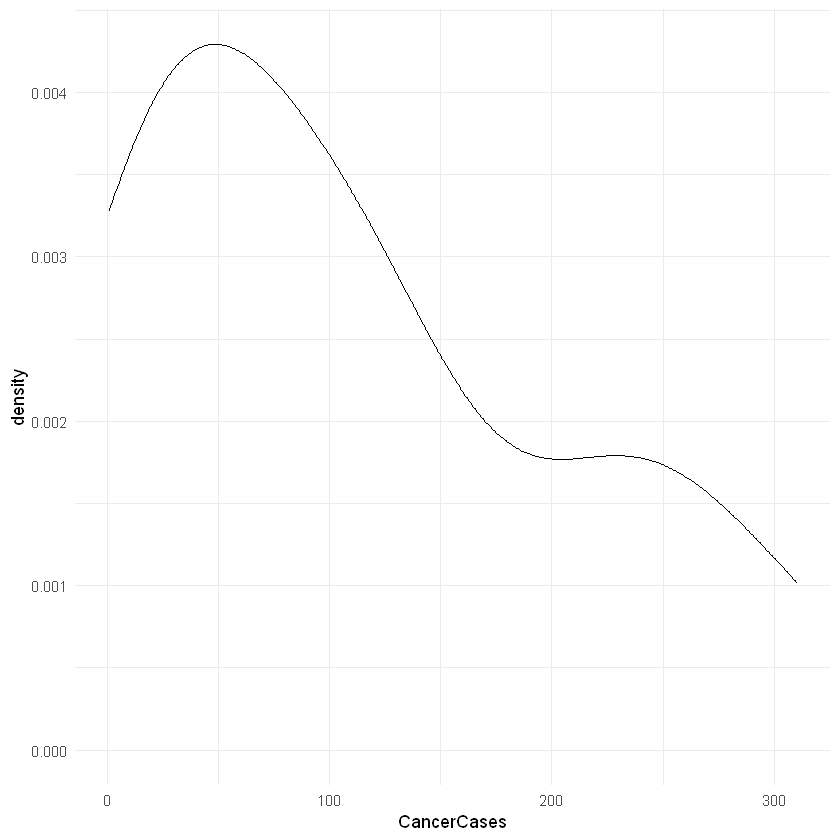

In [125]:
# plot histogram of all cancer COUNTS
SkinCancer %>%
    ggplot()+
    geom_density(aes(CancerCases))+
    theme_minimal()

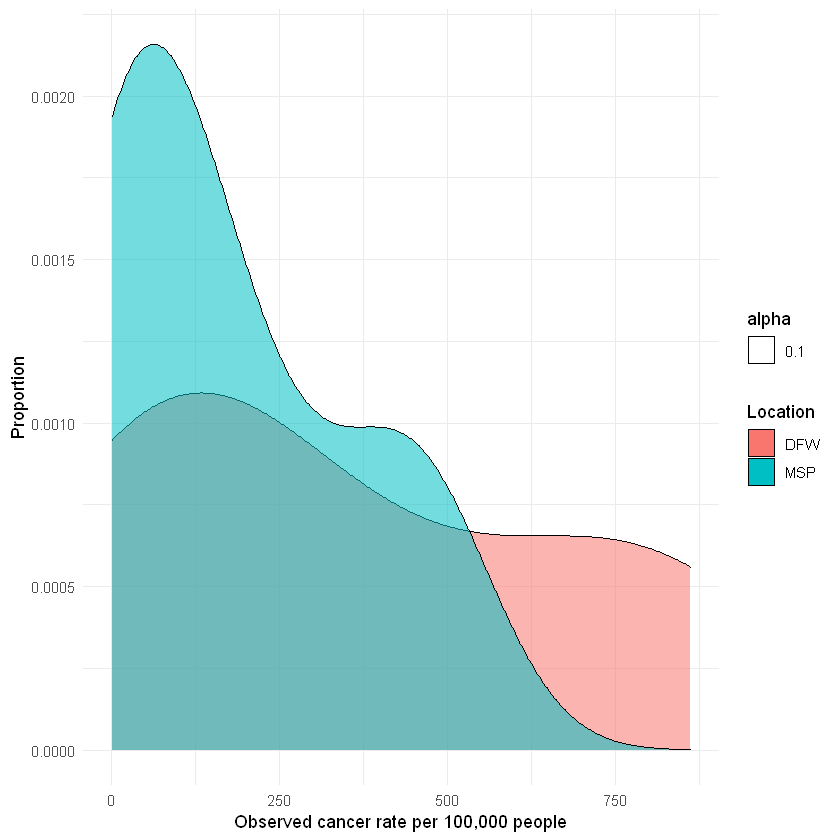

In [6]:
# plot histogram of cancer rates for each city
SkinCancer %>%
    ggplot()+
    geom_density(aes(x=RatePer100k, fill=Location, group=Location, alpha=.1)) +
    theme_minimal() +
    labs(x="Observed cancer rate per 100,000 people",
        y="Proportion")

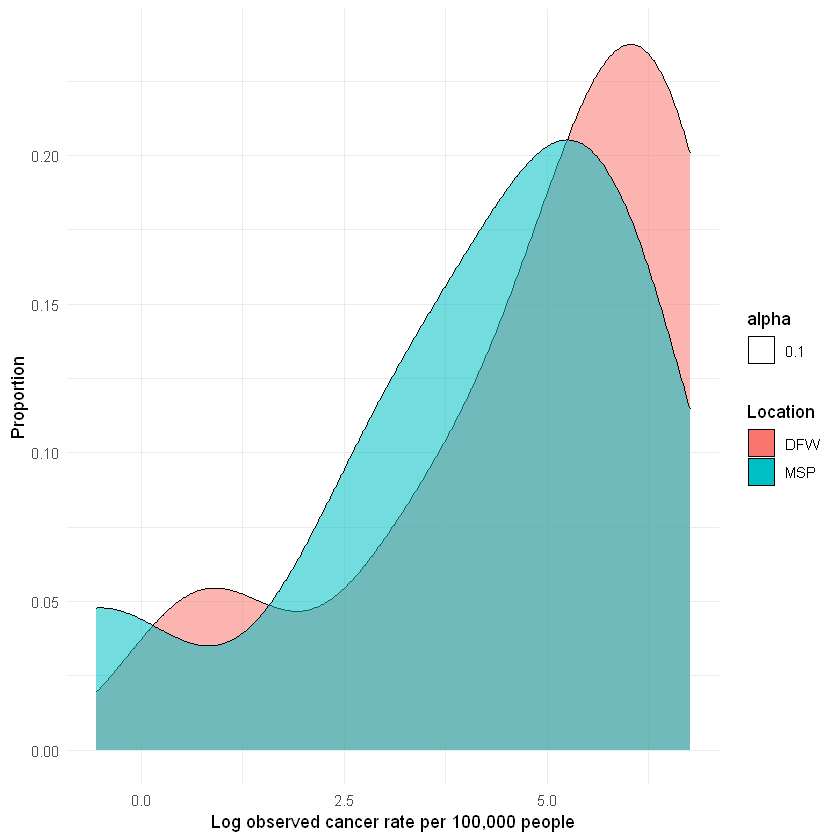

In [7]:
# plot of log observed rates
SkinCancer %>%
    ggplot()+
    geom_density(aes(logRate, fill=Location, group=Location, alpha=.1))  +
    theme_minimal() +
    labs(x="Log observed cancer rate per 100,000 people",
        y="Proportion")

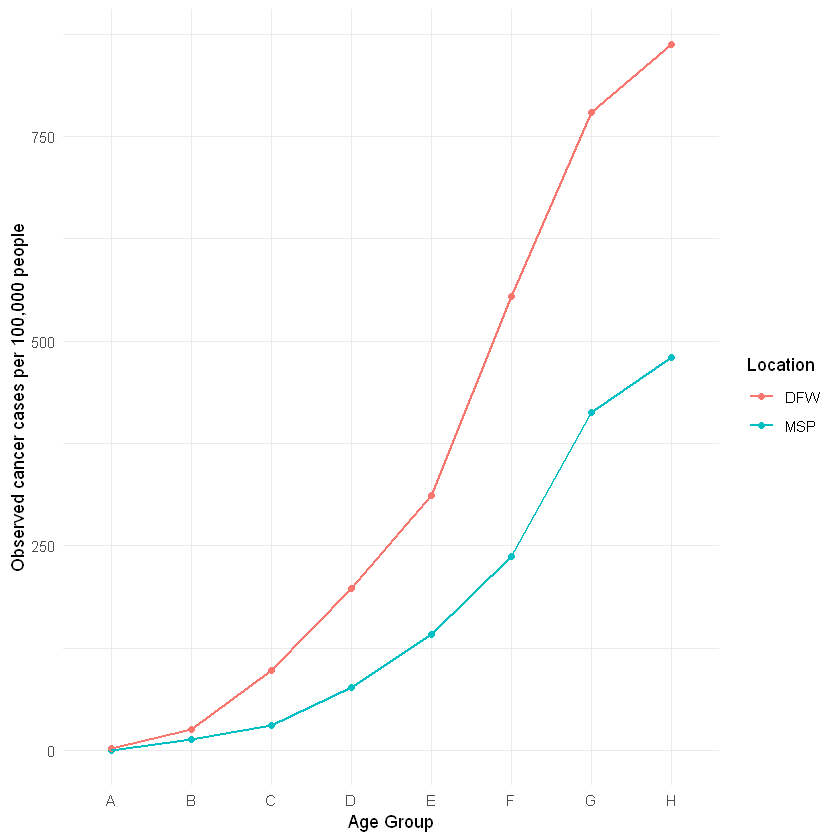

In [73]:
# try line plots instead of density plots?
# plot cancer rates for each age group in each location
SkinCancer %>%
    ggplot(aes(AgeGroup, RatePer100k, group=Location, color=Location)) +
    geom_point()+
    geom_line(size=.7) +
    theme_minimal()+
    labs(x="Age Group",
        y="Observed cancer cases per 100,000 people")

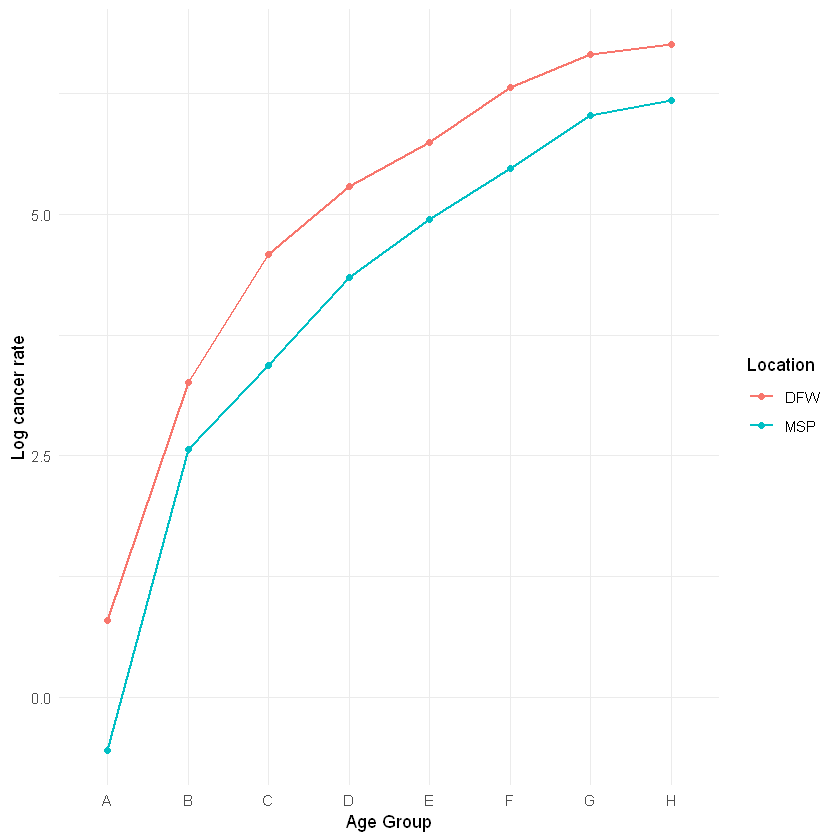

In [74]:
SkinCancer %>%
    ggplot(aes(AgeGroup, logRate, group=Location, color=Location)) +
    geom_point() +
    geom_line(size=.7) +
    theme_minimal()+
    labs(x="Age Group",
        y="Log cancer rate")

#### (c)  Unadjusted RR: 

Fit a Poisson regression model that uses only Location as a predictor, and report and interpret an unadjusted RR, along with a 95% confidence interval. 

In [48]:
mod1 <- glm(CancerCases~Location, data=SkinCancer, offset=log(PopSize), family = "poisson")
summary(mod1)


Call:
glm(formula = CancerCases ~ Location, family = "poisson", data = SkinCancer, 
    offset = log(PopSize))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-23.865   -7.477    3.782   10.396   18.364  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.38418    0.02838 -224.99   <2e-16 ***
LocationMSP -0.74312    0.05213  -14.26   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2790.3  on 15  degrees of freedom
Residual deviance: 2569.8  on 14  degrees of freedom
AIC: 2668

Number of Fisher Scoring iterations: 6


In [11]:
# Unadjusted RR
coef(mod1) #log of unadjusted RR
exp(coef(mod1)) #unadjusted RR is coefficient of Location

(Intercept) LocationMSP 
  -6.384178   -0.743121

(Intercept) LocationMSP 
0.001688055 0.475627180

In [12]:
confint(mod1)
exp(confint(mod1)) #95% CI of Location

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),-6.4403138,-6.3290755
LocationMSP,-0.8460211,-0.6416409


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.001595906,0.001783682
LocationMSP,0.429118979,0.526427917


#### (d)  Include AgeGroup?:  
Fit a model that includes Location while adjusting for AgeGroup. Do you think AgeGroup be included in the model?  Make sure to justify your answer, both conceptually, and numerically. 

In [13]:
mod2 <- update(mod1, .~.+AgeGroup)
summary(mod2)


Call:
glm(formula = CancerCases ~ Location + AgeGroup + offset(log(PopSize)), 
    family = "poisson", data = SkinCancer)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5043  -0.4816   0.0169   0.3697   1.2504  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -10.85360    0.44749 -24.255  < 2e-16 ***
LocationMSP  -0.80428    0.05221 -15.406  < 2e-16 ***
AgeGroupB     2.63019    0.46746   5.627 1.84e-08 ***
AgeGroupC     3.84735    0.45466   8.462  < 2e-16 ***
AgeGroupD     4.59519    0.45103  10.188  < 2e-16 ***
AgeGroupE     5.08728    0.45030  11.298  < 2e-16 ***
AgeGroupF     5.64541    0.44975  12.552  < 2e-16 ***
AgeGroupG     6.05855    0.45032  13.454  < 2e-16 ***
AgeGroupH     6.17819    0.45774  13.497  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2790.340  on 15  degrees of freedom
Residual deviance:    8.195 

In [52]:
# Likelihood ratio test comparing two models
anova(mod1, mod2, test="LRT")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
14,2569.77001,NA,NA,NA
7,8.19505,7,2561.575,0


In [18]:
# comparing AIC
AIC(mod2); AIC(mod1)

[1] 120.4402

[1] 2668.015

#### (e)  Include PropWomen?: 

Now, fit a model that includes Location, AgeGroup, and PropWomen.  Compare this model to the model fit in part (d).  Do you think we should also include PropWomen in the model?  Why of why not? Make sure to justify your answer, both conceptually, and numerically. 

In [53]:
mod3 <- update(mod2, .~.+PropWomen)
summary(mod3)


Call:
glm(formula = CancerCases ~ Location + AgeGroup + PropWomen + 
    offset(log(PopSize)), family = "poisson", data = SkinCancer)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.63465  -0.34481  -0.01724   0.19971   1.03175  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.87136    1.05458  -9.360  < 2e-16 ***
LocationMSP -0.79443    0.05299 -14.992  < 2e-16 ***
AgeGroupB    2.68548    0.47035   5.710 1.13e-08 ***
AgeGroupC    3.87843    0.45568   8.511  < 2e-16 ***
AgeGroupD    4.57861    0.45133  10.145  < 2e-16 ***
AgeGroupE    5.01397    0.45587  10.999  < 2e-16 ***
AgeGroupF    5.51643    0.46681  11.817  < 2e-16 ***
AgeGroupG    5.96972    0.45846  13.021  < 2e-16 ***
AgeGroupH    6.01070    0.48572  12.375  < 2e-16 ***
PropWomen   -1.96369    1.90971  -1.028    0.304    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance:

In [54]:
anova(mod2, mod3, test="LRT")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
7,8.195050,NA,NA,NA
6,7.137383,1,1.057667,0.3037479


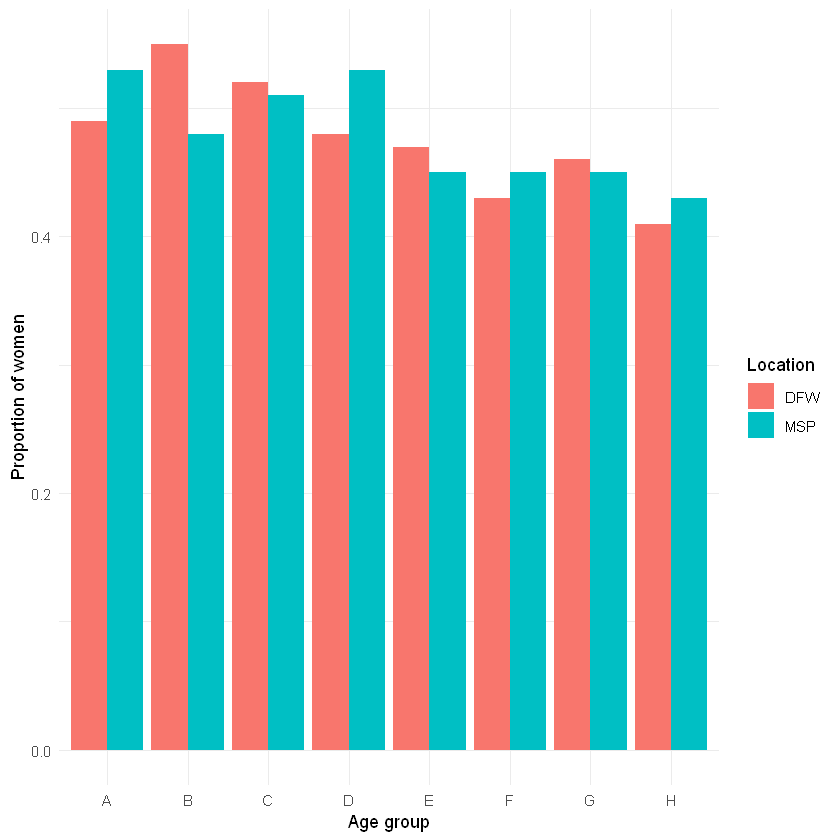

In [70]:
# exploratory plots for PropWomen
# PropWomen ~ location
SkinCancer %>%
    ggplot(aes(AgeGroup, PropWomen, group=Location, fill=Location))+
    geom_bar(stat="identity", position="dodge")+
    theme_minimal()+
    labs(x="Age group", y="Proportion of women")

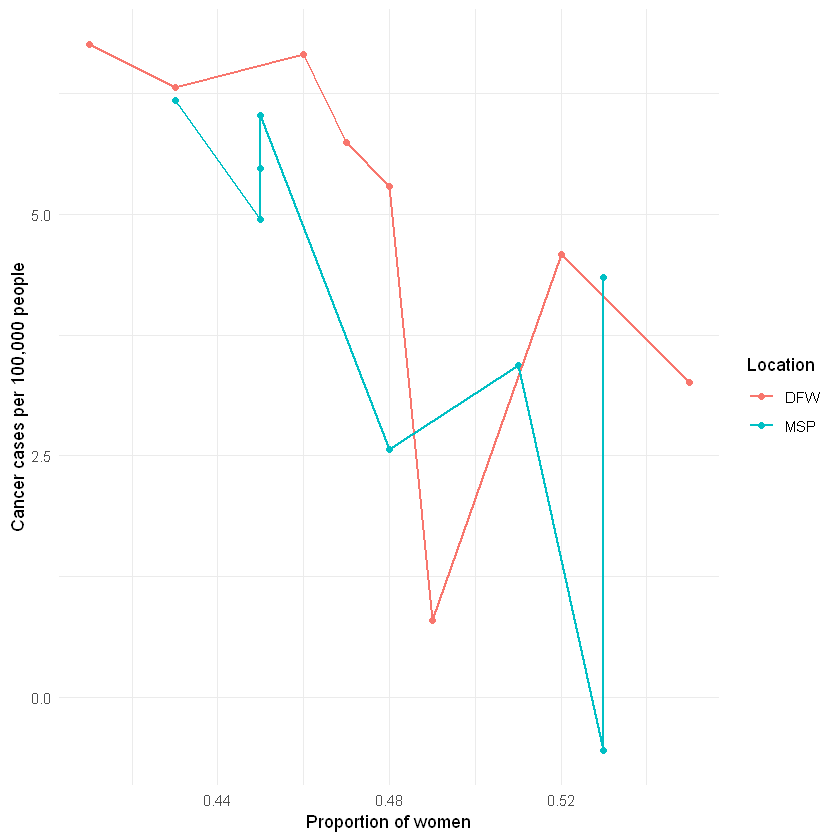

In [72]:
# exploratory plots for PropWomen
# PropWomen ~ Rates
SkinCancer %>%
    ggplot(aes(PropWomen, logRate, group=Location, color=Location))+
    geom_point()+
    geom_line(size=.7)+
    theme_minimal()+
    labs(x="Proportion of women",
        y="Cancer cases per 100,000 people")

#### (f) Adjusted RRs:

Using the model fit in part (e), report and interpret RR(s) relevant to Location.

In [55]:
coef(mod3)

(Intercept) LocationMSP   AgeGroupB   AgeGroupC   AgeGroupD   AgeGroupE 
 -9.8713564  -0.7944325   2.6854773   3.8784252   4.5786067   5.0139729 
  AgeGroupF   AgeGroupG   AgeGroupH   PropWomen 
  5.5164267   5.9697240   6.0106976  -1.9636882

In [56]:
exp(coef(mod3))

(Intercept)  LocationMSP    AgeGroupB    AgeGroupC    AgeGroupD    AgeGroupE 
5.163265e-05 4.518376e-01 1.466520e+01 4.834802e+01 9.737862e+01 1.505015e+02 
   AgeGroupF    AgeGroupG    AgeGroupH    PropWomen 
2.487446e+02 3.913976e+02 4.077677e+02 1.403399e-01

#### (g)  Estimated Rate:

What is the estimated skin cancer rate for Missesota, age group C, with 50% women?  Why might one be cautious in using this model to estimate skin cancer rates? 

In [57]:
# extract coefficients for prediction
interc <- coef(mod3)[1]
interc
loc <- coef(mod3)[2]
loc
ageC <- coef(mod3)[4]
ageC
propW <- coef(mod3)[10]
propW

pred <- interc + loc + ageC + .50*propW #log of cancer rate
pred
exp(pred)

(Intercept) 
  -9.871356

LocationMSP 
 -0.7944325

AgeGroupC 
 3.878425

PropWomen 
-1.963688

(Intercept) 
  -7.769208

(Intercept) 
0.0004225479

#### (h)  Over-dispersion:

Does there appear to be over-dispersion in the model fit in part (e)?  If there were over-dispersion, what might be the cause of this? What are potential solutions? (you don’t need to implement any of these solutions, you may simply name them) 

In [60]:
# check for overdispersion
PearsonX <- sum(residuals(mod3, type="pearson")^2)
PearsonX

[1] 6.982657

In [61]:
# calculate dispersion parameter
# if disp is much larger than 1, then there's overdispersion
disp <- PearsonX/mod3$df.residual
disp

[1] 1.163776

In [62]:
# calculate approximate dispersion parameter, same assumption
approx.Disp <- mod3$deviance / mod3$df.residual
approx.Disp

[1] 1.189564

In [52]:
# no overdispersion here.

#### (i) Effect Modification:  

Now, consider a model that includes an effect modification term.  Test if the effect modification is statistically significant.  Suppose we did include an effect modification for ‘Location*AgeGroup’.  Explain in words what this would imply about the relationship between cancer rates, location and age group.  You may use numeric examples and/or pictures to aid your explanation. 

In [64]:
mod4 <- update(mod3, .~.+Location:AgeGroup)
summary(mod4)


Call:
glm(formula = CancerCases ~ Location + AgeGroup + PropWomen + 
    Location:AgeGroup + offset(log(PopSize)), family = "poisson", 
    data = SkinCancer)

Deviance Residuals: 
 [1]  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Coefficients: (1 not defined because of singularities)
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             7.7056    28.0544   0.275  0.78357    
LocationMSP             0.1670     1.1881   0.141  0.88824    
AgeGroupB               4.7231     3.2233   1.465  0.14284    
AgeGroupC               4.9226     1.5530   3.170  0.00153 ** 
AgeGroupD               4.1235     0.9095   4.534 5.79e-06 ***
AgeGroupE               4.1999     1.4298   2.937  0.00331 ** 
AgeGroupF               3.2701     3.6560   0.894  0.37109    
AgeGroupG               4.7389     1.9768   2.397  0.01652 *  
AgeGroupH               2.9600     4.7994   0.617  0.53741    
PropWomen             -37.6071    56.7973  -0.662  0.50789    
LocationMSP:AgeG

In [65]:
# comparing model 3 and model 4
anova(mod3, mod4, test="LRT")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
6,7.137383e+00,NA,NA,NA
0,9.370282e-14,6,7.137383,0.3083289
